# Preparación del entorno

In [8]:
from ultralytics import YOLO
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
)

# Rutas
DATASET_DIR = Path("dataset_cls")
TRAIN_DIR = DATASET_DIR / "train"
VAL_DIR   = DATASET_DIR / "val"
TEST_DIR  = DATASET_DIR / "test"

assert TRAIN_DIR.exists() and VAL_DIR.exists() and TEST_DIR.exists(), "Revisa rutas train/val/test"

# Clases
CLASSES = sorted([d.name for d in TRAIN_DIR.iterdir() if d.is_dir()])
print("Clases:", CLASSES)

# Modelo base (clasificación)
BASE_MODEL = "yolo11s-cls.pt"

Clases: ['defecto', 'no_defecto']


# Predecir carpeta + sacar DF

In [9]:
def predict_folder_to_df(model: YOLO, folder: Path, classes: list[str], imgsz: int = 224):
    image_paths = [p for p in folder.rglob("*") if p.suffix.lower() in [".jpg",".jpeg",".png",".bmp",".tif",".tiff"]]
    rows = []
    for img_path in image_paths:
        r = model.predict(img_path, imgsz=imgsz, verbose=False)[0]
        pred_id = int(r.probs.top1)
        conf = float(r.probs.top1conf)
        pred_name = r.names[pred_id]
        true_name = img_path.parent.name  # nombre carpeta = etiqueta real

        rows.append({
            "image_path": str(img_path),
            "image": img_path.name,
            "true_class": true_name,
            "pred_class": pred_name,
            "confidence": conf
        })
    return pd.DataFrame(rows)

# Métricas poniendo el foco en el defecto

In [10]:
def compute_metrics_binary(df_pred: pd.DataFrame, positive_class: str = "defecto"):
    y_true = df_pred["true_class"].tolist()
    y_pred = df_pred["pred_class"].tolist()

    acc = accuracy_score(y_true, y_pred)

    # Para binario, calculamos precision/recall/f1 para la clase positiva
    report = classification_report(y_true, y_pred, digits=4, output_dict=True, zero_division=0)
    pos = report.get(positive_class, {"precision":0, "recall":0, "f1-score":0})

    return {
        "accuracy": acc,
        f"precision_{positive_class}": pos["precision"],
        f"recall_{positive_class}": pos["recall"],
        f"f1_{positive_class}": pos["f1-score"],
        "report_dict": report
    }

# Entrenar 1 experimento (“final” de prueba)

In [11]:
RUN_NAME = "final_train"

model = YOLO(BASE_MODEL)
train_res = model.train(
    data=str(DATASET_DIR),
    epochs=50,
    imgsz=224,
    batch=32,
    patience=10,
    optimizer="Adam",
    lr0=1e-3,
    project="runs_cls",
    name=RUN_NAME,
    verbose=True
)

BEST_PT = Path(train_res.save_dir) / "weights" / "best.pt"
print("Best model:", BEST_PT)

New https://pypi.org/project/ultralytics/8.4.2 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.252  Python-3.13.5 torch-2.9.1+cpu CPU (Intel Core(TM) Ultra 7 165H)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset_cls, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=final_train3, nbs=64, nms=False, opset=None, optim

# Evaluación en TEST (con matriz de confusión + CSV)

,image_path,image,true_class,pred_class,confidence
0,dataset_cls\test\defecto\kos02_Part6.jpg,kos02_Part6.jpg,defecto,defecto,0.861379
1,dataset_cls\test\defecto\kos08_Part2.jpg,kos08_Part2.jpg,defecto,no_defecto,0.999755
2,dataset_cls\test\defecto\kos09_Part6.jpg,kos09_Part6.jpg,defecto,defecto,0.999998
3,dataset_cls\test\defecto\kos16_Part5.jpg,kos16_Part5.jpg,defecto,defecto,0.999999
4,dataset_cls\test\defecto\kos17_Part5.jpg,kos17_Part5.jpg,defecto,defecto,1.000000


CSV guardado: predicciones_test.csv
Accuracy test: 0.9783
Recall defecto: 0.8571
F1 defecto: 0.9231

=== Classification Report ===
              precision    recall  f1-score   support

     defecto     1.0000    0.8571    0.9231         7
  no_defecto     0.9750    1.0000    0.9873        39

    accuracy                         0.9783        46
   macro avg     0.9875    0.9286    0.9552        46
weighted avg     0.9788    0.9783    0.9776        46



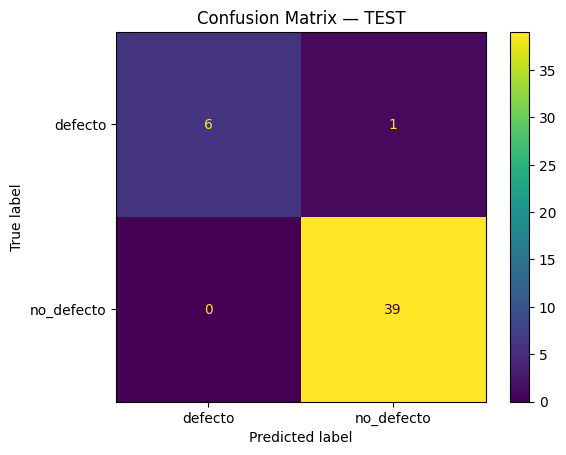

In [12]:
model_best = YOLO(str(BEST_PT))

df_test = predict_folder_to_df(model_best, TEST_DIR, CLASSES, imgsz=224)
display(df_test.head())

df_test.to_csv("predicciones_test.csv", index=False)
print("CSV guardado: predicciones_test.csv")

# Métricas
m = compute_metrics_binary(df_test, positive_class="defecto")
print(f"Accuracy test: {m['accuracy']:.4f}")
print(f"Recall defecto: {m['recall_defecto']:.4f}")
print(f"F1 defecto: {m['f1_defecto']:.4f}")

# Report
print("\n=== Classification Report ===")
print(classification_report(df_test["true_class"], df_test["pred_class"], digits=4, zero_division=0))

# Matriz de confusión
labels = CLASSES
cm = confusion_matrix(df_test["true_class"], df_test["pred_class"], labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(values_format="d")
plt.title("Confusion Matrix — TEST")
plt.show()

# Errores más graves (alta confianza pero mal)

In [13]:
df_errors = df_test[df_test["true_class"] != df_test["pred_class"]].copy()
df_errors = df_errors.sort_values("confidence", ascending=False)

print("Errores:", len(df_errors))
display(df_errors.head(15))

Errores: 1


,image_path,image,true_class,pred_class,confidence
1,dataset_cls\test\defecto\kos08_Part2.jpg,kos08_Part2.jpg,defecto,no_defecto,0.999755


# Grid-search (guardar CSV + eligir el mejor)

In [14]:
import itertools
from pathlib import Path
import pandas as pd

GRID = {
    "imgsz": [224],
    "batch": [16, 32],
    "lr0": [1e-3, 5e-4],
    "epochs": [100],
    "optimizer": ["Adam"],
    "patience": [10],         # early stopping
}

SELECT_BY = "recall_defecto"

experiments = list(itertools.product(
    GRID["imgsz"], GRID["batch"], GRID["lr0"], GRID["epochs"], GRID["optimizer"], GRID["patience"]
))

all_rows = []

for i, (imgsz, batch, lr0, epochs, optimizer, patience) in enumerate(experiments, start=1):
    exp_name = f"exp{i}_img{imgsz}_b{batch}_lr{lr0}_e{epochs}_{optimizer}_pat{patience}"
    print("\n==>", exp_name)

    model = YOLO(BASE_MODEL)
    train_res = model.train(
        data=str(DATASET_DIR),
        imgsz=imgsz,
        batch=batch,
        lr0=lr0,
        epochs=epochs,
        optimizer=optimizer,
        patience=patience,
        val=True,
        project="runs_cls",
        name=exp_name,
        verbose=False
    )

    best_pt = Path(train_res.save_dir) / "weights" / "best.pt"
    model_best = YOLO(str(best_pt))

    df_test = predict_folder_to_df(model_best, TEST_DIR, CLASSES, imgsz=imgsz)
    metrics = compute_metrics_binary(df_test, positive_class="defecto")

    all_rows.append({
        "exp_name": exp_name,
        "best_pt": str(best_pt),
        "imgsz": imgsz,
        "batch": batch,
        "lr0": lr0,
        "epochs_max": epochs,
        "patience": patience,
        "accuracy": metrics["accuracy"],
        "precision_defecto": metrics["precision_defecto"],
        "recall_defecto": metrics["recall_defecto"],
        "f1_defecto": metrics["f1_defecto"],
    })

df_grid = pd.DataFrame(all_rows)
df_grid.to_csv("grid_results.csv", index=False)
display(df_grid.sort_values(SELECT_BY, ascending=False).head(10))
print("Guardado: grid_results.csv")


==> exp1_img224_b16_lr0.001_e100_Adam_pat10
New https://pypi.org/project/ultralytics/8.4.2 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.252  Python-3.13.5 torch-2.9.1+cpu CPU (Intel Core(TM) Ultra 7 165H)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset_cls, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=exp1

,exp_name,best_pt,imgsz,batch,lr0,epochs_max,patience,accuracy,precision_defecto,recall_defecto,f1_defecto
0,exp1_img224_b16_lr0.001_e100_Adam_pat10,C:\Users\User\Documents\GitHub\grupo1reto2\Cla...,224,16,0.0010,100,10,0.978261,1.0,0.857143,0.923077
1,exp2_img224_b16_lr0.0005_e100_Adam_pat10,C:\Users\User\Documents\GitHub\grupo1reto2\Cla...,224,16,0.0005,100,10,0.978261,1.0,0.857143,0.923077
2,exp3_img224_b32_lr0.001_e100_Adam_pat10,C:\Users\User\Documents\GitHub\grupo1reto2\Cla...,224,32,0.0010,100,10,0.978261,1.0,0.857143,0.923077
3,exp4_img224_b32_lr0.0005_e100_Adam_pat10,C:\Users\User\Documents\GitHub\grupo1reto2\Cla...,224,32,0.0005,100,10,0.956522,1.0,0.714286,0.833333


Guardado: grid_results.csv


# Gráficas para comparar y elegir

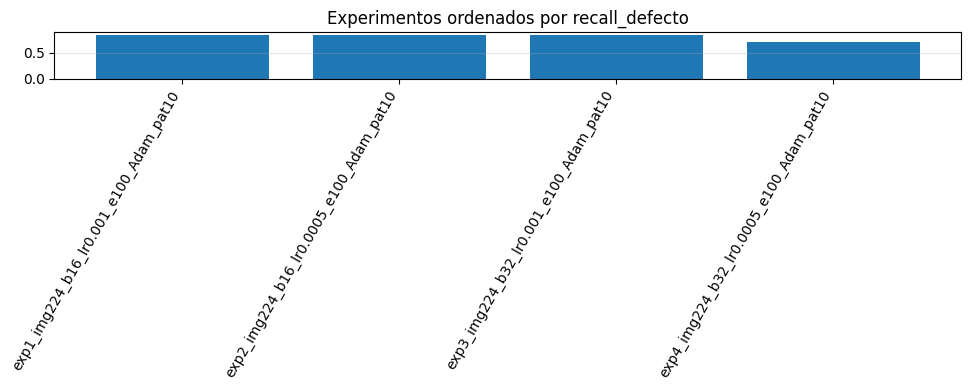

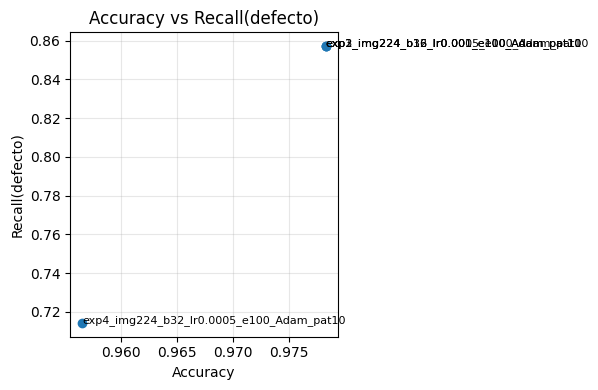

In [15]:
%matplotlib inline
plt.figure(figsize=(10,4))
df_sorted = df_grid.sort_values(SELECT_BY, ascending=False)
plt.bar(df_sorted["exp_name"], df_sorted[SELECT_BY])
plt.xticks(rotation=60, ha="right")
plt.title(f"Experimentos ordenados por {SELECT_BY}")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(df_grid["accuracy"], df_grid["recall_defecto"])
for _, r in df_grid.iterrows():
    plt.text(r["accuracy"], r["recall_defecto"], r["exp_name"], fontsize=8)
plt.xlabel("Accuracy")
plt.ylabel("Recall(defecto)")
plt.title("Accuracy vs Recall(defecto)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Dado que varios experimentos alcanzaron métricas idénticas en términos de accuracy, recall y F1-score para la clase defecto, se seleccionó el experimento exp2 por presentar una tasa de aprendizaje más conservadora y un tamaño de batch moderado, lo que favorece una mayor estabilidad del entrenamiento y un menor riesgo de sobreajuste.

In [18]:
FINAL_MODEL_PATH = "runs_cls/exp2_img224_b16_lr0.0005_e100_Adam_pat10/weights/best.pt"

In [19]:
# Errores que se le escapan al mejor modelo:

df_errors = df_test[
    (df_test["true_class"] == "defecto") &
    (df_test["pred_class"] == "no_defecto")
].sort_values("confidence", ascending=False)

display(df_errors.head(10))

,image_path,image,true_class,pred_class,confidence
1,dataset_cls\test\defecto\kos08_Part2.jpg,kos08_Part2.jpg,defecto,no_defecto,0.999327
0,dataset_cls\test\defecto\kos02_Part6.jpg,kos02_Part6.jpg,defecto,no_defecto,0.604673
